# Wasserstein GAN - MNIST

In [29]:
one = X_train[9].reshape(28,28)

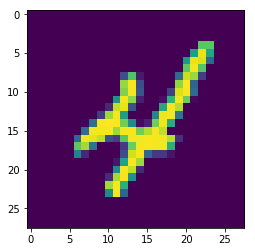

In [30]:
from matplotlib import pyplot as plt
plt.imshow(one, interpolation='nearest')
plt.show()

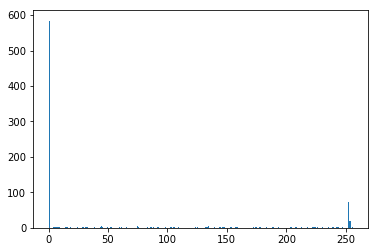

In [28]:
plt.hist(one.ravel(),256,[0,256]); plt.show()

In [1]:
%matplotlib inline
import importlib
import utils2; importlib.reload(utils2)
from utils2 import *

from tqdm import tqdm

/opt/anaconda/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
import torch_utils; importlib.reload(torch_utils)
from torch_utils import *
import torch.nn
import torch.nn.parallel
import torch.nn.functional as F

from torch import FloatTensor as FT

In [3]:
#Batchsize, image size and size of noise vector
bs,sz,nz = 64,28,100

In [4]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [5]:
X_train = np.expand_dims(X_train, -1); X_train.shape

(60000, 28, 28, 1)

In [6]:
X_train=X_train.reshape((60000, 1, 28, 28))

In [7]:
X_traint = torch.from_numpy(X_train)
y_traint = torch.from_numpy(y_train)

In [8]:
X_traint = X_traint.float()

In [9]:
datas = torch.utils.data.TensorDataset(X_traint, y_traint)

In [10]:
dataloader = torch.utils.data.DataLoader(datas, bs, True)

In [11]:
n = len(dataloader); n

938

In [12]:
X_train.shape

(60000, 1, 28, 28)

### Generator

In [84]:
 class GAN_G(nn.Module):
        #inF: number of input features/channels
        #outF: number of output channels
        #kS: kernel size
        #strd: strides
        #p: padding
        #uOut: Output height width of upsampling 
        #uOutF: Features output of upsampling
        def up_block(self, uOutF, outF, uOut, kS, strd, p, bn=True):
            upblock = nn.Sequential(
                nn.Upsample((uOutF, uOut, uOut)),
                nn.Conv2d(uOutF, outF, kS, strd, p, bias=False),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(outF)
            )
            return upblock
        def __init__(self, sz, nz):
            super(GAN_G, self).__init__()
            
            self.initial = nn.Sequential(
            nn.Linear(nz, 512*7*7),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm2d(512*7*7),
            )
            
            self.upblock1 = nn.Sequential(
                nn.Conv2d(512, 64, 3, 1, 1, bias=False),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(64)
            )
            self.upblock2 = nn.Sequential(
                nn.Conv2d(64, 32, 3, 1, 1, bias=False),
                nn.ReLU(inplace=True),
                nn.BatchNorm2d(32)
            )
            
            self.final = nn.Sequential(
                nn.Conv2d(32, 1, 1, bias=False),
                nn.Tanh(),
            )  
        def forward(self, input):
            x = self.initial(input)
            x = x.view(-1, 512, 7, 7)
            x = F.upsample(x, scale_factor=2)
            x = self.upblock1(x)
            x = F.upsample(x, scale_factor=2)
            x = self.upblock2(x)
            x = self.final(x)
            return x

            
            

### Discriminator

In [85]:
class GAN_D(nn.Module):

    def __init__(self, nc=1):
        super(GAN_D, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(1, 256, 5, 2, 0, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(256, 512, 5, 2, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        
        self.dense = nn.Sequential(
            nn.Linear(512*4*4, 256),
            nn.LeakyReLU(0.2),
            nn.Linear(256, 1),
        )
        
        
    def forward(self, input):
        x = self.conv1(input)
        x = self.conv2(x)
        x = x.view(-1, 512*4*4)
        x = self.dense(x)
        return x

### Weight functions

In [86]:
def weights_init(m):
    if isinstance(m, (nn.Conv2d)): 
        m.weight.data.normal_(0.0, 0.02)
    elif isinstance(m, nn.BatchNorm2d):
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)

### Training

In [87]:
netG = GAN_G(sz, nz).cuda()
netG.apply(weights_init);

In [88]:
netD = GAN_D(1).cuda()
netD.apply(weights_init);

In [ ]:
fake = netG(create_noise(real.size()[0]))

In [89]:
def Var(*parms): return Variable(FT(*parms).cuda())

In [90]:
def create_noise(b): 
    return Variable(FT(b, nz).cuda().normal_(0, 1))

In [91]:
# Input placeholder
input = Var(bs, 100)
# Fixed noise used just for visualizing images when done
fixed_noise = create_noise(bs)
# The numbers 0 and -1
one = np.array([1]*bs).astype('float32')
one = torch.from_numpy(one).cuda()
one = one.view(64,1)
mone = one * -1

In [94]:
optimizerD = optim.RMSprop(netD.parameters(), lr = 1e-5)
optimizerG = optim.RMSprop(netG.parameters(), lr = 1e-5)

In [95]:
G_params = list(netG.parameters())
D_params = list(netD.parameters())

In [96]:
def step_D(v, init_grad):
    err = netD(v)
    err.backward(init_grad)
    return err

In [97]:
def make_trainable(net, val): 
    for p in net.parameters(): p.requires_grad = val

### Train loop

In [126]:
def train(niter, first=True):
    gen_iterations = 100
    for epoch in tqdm(range(niter)):
        data_iter =  iter(dataloader)
        i = 0
        while i < n:
            make_trainable(netD, True)
            d_iters = (100 if first and (gen_iterations < 25) or gen_iterations % 500 == 0 
                       else 5)
            j = 0.01
            while j < d_iters and i < n:
                j+=1; i+=100
                for p in netD.parameters(): p.data.clamp_(-0.01, 0.01)
                real = Variable(next(data_iter)[0].cuda())
                input.data.resize_(real.size())
                netD.zero_grad()
                errD_real = netD(real)
                
                fake = netG(create_noise(real.size()[0]))
                input.data.resize_(real.size()).copy_(fake.data)
                errD_fake = netD(fake)
                dloss = -(torch.mean(errD_real) - torch.mean(errD_fake))
                dloss.backward()
                optimizerD.step()
            
            make_trainable(netD, False)
            netG.zero_grad()
            errD_fake = netD(netG(create_noise(bs)))
            gloss = -torch.mean(errD_fake)
            gloss.backward()
            optimizerG.step()
            
            if gen_iterations % 300 == 0:
                print('Iter-{}; D_loss: {}; G_loss: {}'
                .format(gen_iterations, dloss.cpu().data.numpy(), gloss.cpu().data.numpy()))
            gen_iterations += 1
                

### Test

In [55]:
real = Variable(next(iter(dataloader))[0])

In [127]:
%time train(2000, True)

  5%|▌         | 101/2000 [00:31<09:58,  3.17it/s]

Iter-300; D_loss: [-1.392114]; G_loss: [0.641057]


 13%|█▎        | 251/2000 [01:19<09:12,  3.17it/s]

Iter-600; D_loss: [-1.3972178]; G_loss: [0.6373931]


 20%|██        | 401/2000 [02:06<08:25,  3.16it/s]

Iter-900; D_loss: [-1.4144549]; G_loss: [0.63465506]


 28%|██▊       | 551/2000 [02:54<07:38,  3.16it/s]

Iter-1200; D_loss: [-1.3726422]; G_loss: [0.6383203]


 35%|███▌      | 701/2000 [03:41<06:50,  3.16it/s]

Iter-1500; D_loss: [-1.4534163]; G_loss: [0.64985996]


 43%|████▎     | 851/2000 [04:29<06:03,  3.16it/s]

Iter-1800; D_loss: [-1.4152188]; G_loss: [0.651723]


 50%|█████     | 1001/2000 [05:17<05:16,  3.16it/s]

Iter-2100; D_loss: [-1.4404333]; G_loss: [0.65195864]


 58%|█████▊    | 1151/2000 [06:05<04:29,  3.15it/s]

Iter-2400; D_loss: [-1.4311123]; G_loss: [0.6583094]


 65%|██████▌   | 1301/2000 [06:52<03:41,  3.15it/s]

Iter-2700; D_loss: [-1.438383]; G_loss: [0.6551415]


 73%|███████▎  | 1451/2000 [07:40<02:54,  3.15it/s]

Iter-3000; D_loss: [-1.4536617]; G_loss: [0.66200626]


 80%|████████  | 1601/2000 [08:27<02:06,  3.15it/s]

Iter-3300; D_loss: [-1.4585309]; G_loss: [0.6591966]


 88%|████████▊ | 1751/2000 [09:15<01:19,  3.15it/s]

Iter-3600; D_loss: [-1.4658945]; G_loss: [0.6613513]


 95%|█████████▌| 1901/2000 [10:02<00:31,  3.16it/s]

Iter-3900; D_loss: [-1.4485534]; G_loss: [0.6603129]


100%|██████████| 2000/2000 [10:33<00:00,  3.16it/s]

CPU times: user 8min 58s, sys: 1min 34s, total: 10min 33s
Wall time: 10min 33s


In [114]:
fake = netG(fixed_noise).data.cpu()

In [115]:
import torchvision
from torchvision.utils import make_grid

In [116]:
%matplotlib inline
def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')


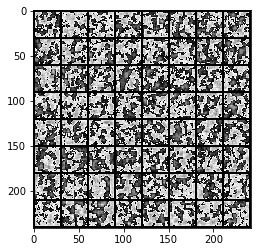

In [117]:
show(torchvision.utils.make_grid(fake))